In [1]:
# !pip install tensorflow
# !pip install nltk
# !pip install wordcloud
# !pip install surprise
#sqlite3 -header -csv track_metadata.db "SELECT * FROM songs;" > track_metadata.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split,cross_validate
from surprise import SVD, accuracy
from surprise import KNNBasic
import os
from tensorflow.keras import backend as K
import tables

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from surprise import SVDpp, Reader, Dataset
from sklearn.preprocessing import LabelEncoder

2023-04-27 21:35:03.394880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 21:35:06.184979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from wordcloud import WordCloud

# # Download necessary resources from NLTK
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


False

### TASTE PROFILE DATA

In [4]:
taste_profile = pd.read_csv('/home/016651544/datasets/train_triplets.txt',sep='\t',header=None,names = ['user_id','song_id','play_count'],nrows = 2000000)
taste_profile.shape

(2000000, 3)

In [5]:
taste_profile.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [6]:
# Compute quartiles for the play_count of users and year of publication columns
q1_play_count = taste_profile['play_count'].quantile(0.25)
q3_play_count = taste_profile['play_count'].quantile(0.75)
iqr_play_count = q3_play_count - q1_play_count
lower_play_count = q1_play_count - 1.5 * iqr_play_count
upper_play_count = q3_play_count + 1.5 * iqr_play_count
print(q1_play_count, q3_play_count,lower_play_count, upper_play_count)

# Identify and remove outliers based on IQR
taste_profile = taste_profile[(taste_profile['play_count'] >= lower_play_count) & (taste_profile['play_count'] <= upper_play_count)]
taste_profile.shape

1.0 3.0 -2.0 6.0


(1834519, 3)

In [7]:
taste_profile.song_id.nunique()

188992

### METADATA

In [8]:
# Convert the table to a Pandas DataFrame
metadata_table_df = pd.read_csv('/home/016651544/datasets/track_metadata.csv')
metadata_table_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,NaN,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [9]:
# metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
# metadata_table_df.head()
song_ids = taste_profile["song_id"].unique().astype(str)

In [10]:
metadata_df = pd.merge(pd.DataFrame(song_ids,columns=['song_id']),metadata_table_df,on="song_id",how='left')
metadata_df.head()

,song_id,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,SOAKIMP12A8C130995,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,ARC8CQZ1187B98DECA,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,112.63955,0.832012,0.677482,0,2093263,-1,0
1,SOAPDEY12A81C210A9,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,ARHYUI71187FB48366,8a7cf497-dc5c-4523-932d-3fcbc9a69d38,Billy Preston,153.59955,0.580555,0.482492,1974,3072847,-1,0
2,SOBBMDR12A8C13253B,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,ARC1SF21187FB51D0F,7bc8dd01-35ea-4b18-a64d-3a364dc76a52,Paco De Lucia,358.24281,0.633119,0.417718,1976,2631392,-1,0
3,SOBFNSP12AF72A0E22,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,ARMS97V1187B99DD98,023d64c9-93db-4a20-8c5c-2efa1a53481a,Josh Rouse,266.34404,0.675339,0.509058,2002,413957,-1,0
4,SOBFOVM12A58A7D494,TRAHZNE128F9341B86,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,ARI4V0E1187B9B6FC2,87ebbe67-3910-4521-a418-4fe53eb912b7,The Dead 60s,141.42649,0.650281,0.451749,0,5674853,-1,0


### EDA on MetaData

In [11]:
metadata_df.replace("",np.nan,inplace=True)

In [12]:
# metadata_df.idx_artist_terms.value_counts(),metadata_df.idx_similar_artists.value_counts(), metadata_df.artist_7digitalid.value_counts(),artist_playmeid
# metadata_df.track_7digitalid.value_counts()

In [13]:
metadata_df.isna().sum()

song_id                  0
track_id                 0
title                    2
release                  0
artist_id                0
artist_mbid           4279
artist_name              0
duration                 0
artist_familiarity       0
artist_hotttnesss        0
year                     0
track_7digitalid         0
shs_perf                 0
shs_work                 0
dtype: int64

In [14]:
values = {'song_hotttnesss': 0,'artist_familiarity': 0, 'title': "Unknown"}
metadata_df.fillna(value= values,inplace=True)
metadata_df.isna().sum()

song_id                  0
track_id                 0
title                    0
release                  0
artist_id                0
artist_mbid           4279
artist_name              0
duration                 0
artist_familiarity       0
artist_hotttnesss        0
year                     0
track_7digitalid         0
shs_perf                 0
shs_work                 0
dtype: int64

In [15]:
metadata_df.columns,metadata_df.dtypes

(Index(['song_id', 'track_id', 'title', 'release', 'artist_id', 'artist_mbid',
        'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
        'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
       dtype='object'),
 song_id                object
 track_id               object
 title                  object
 release                object
 artist_id              object
 artist_mbid            object
 artist_name            object
 duration              float64
 artist_familiarity    float64
 artist_hotttnesss     float64
 year                    int64
 track_7digitalid        int64
 shs_perf                int64
 shs_work                int64
 dtype: object)

In [16]:
metadata_df.artist_familiarity.value_counts()

0.000000    272
0.803220    115
0.833968    106
0.929030    102
0.838409     93
           ... 
0.592357      1
0.455168      1
0.488181      1
0.424525      1
0.624586      1
Name: artist_familiarity, Length: 24525, dtype: int64

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'artist_familiarity'}>],
       [<Axes: title={'center': 'artist_hotttnesss'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'shs_perf'}>,
        <Axes: title={'center': 'shs_work'}>]], dtype=object)

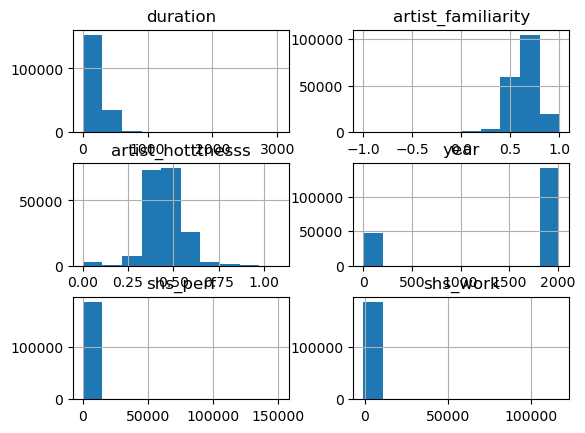

In [17]:
metadata_df[['duration', 'artist_familiarity', 'artist_hotttnesss', 'year', 'shs_perf', 'shs_work']].hist()

In [18]:
# metadata_df.drop(columns =['artist_mbid','shs_work','shs_perf','track_7digitalid','artist_id'],inplace=True)

In [19]:
metadata_df.columns

Index(['song_id', 'track_id', 'title', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'track_7digitalid', 'shs_perf', 'shs_work'],
      dtype='object')

### EDA

In [20]:
eda_data = pd.merge(taste_profile, metadata_df, on='song_id',how='left')
eda_data.head()

,user_id,song_id,play_count,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,The Cove,Thicker Than Water,ARC8CQZ1187B98DECA,ff6e677f-91dd-4986-a174-8db0474b1799,Jack Johnson,112.63955,0.832012,0.677482,0,2093263,-1,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Nothing from Nothing,To Die For,ARHYUI71187FB48366,8a7cf497-dc5c-4523-932d-3fcbc9a69d38,Billy Preston,153.59955,0.580555,0.482492,1974,3072847,-1,0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Entre Dos Aguas,Flamenco Para Niños,ARC1SF21187FB51D0F,7bc8dd01-35ea-4b18-a64d-3a364dc76a52,Paco De Lucia,358.24281,0.633119,0.417718,1976,2631392,-1,0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Under Cold Blue Stars,Under Cold Blue Stars,ARMS97V1187B99DD98,023d64c9-93db-4a20-8c5c-2efa1a53481a,Josh Rouse,266.34404,0.675339,0.509058,2002,413957,-1,0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,TRAHZNE128F9341B86,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,ARI4V0E1187B9B6FC2,87ebbe67-3910-4521-a418-4fe53eb912b7,The Dead 60s,141.42649,0.650281,0.451749,0,5674853,-1,0


In [25]:
# Most popular songs
song_counts = eda_data['title'].value_counts()
top_songs = song_counts.head(10)
print('Top 10 most popular songs:')
for i, (song_id, count) in enumerate(top_songs.iteritems(), 1):
    print(f'{i}. Song: {song_id}, Count: {count}')
print()

Top 10 most popular songs:
1. Song: Use Somebody, Count: 3882
2. Song: Sehr kosmisch, Count: 3879
3. Song: Dog Days Are Over (Radio Edit), Count: 3217
4. Song: Yellow, Count: 2851
5. Song: Undo, Count: 2807
6. Song: Somebody To Love, Count: 2735
7. Song: Secrets, Count: 2697
8. Song: You're The One, Count: 2624
9. Song: Revelry, Count: 2545
10. Song: Love Story, Count: 2537



/tmp/ipykernel_9413/449051530.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (song_id, count) in enumerate(top_songs.iteritems(), 1):


In [26]:

# Most popular artists
artist_counts = eda_data['artist_name'].value_counts()
top_artists = artist_counts.head(10)
print('Top 10 most popular artists:')
for i, (artist_name, count) in enumerate(top_artists.iteritems(), 1):
    print(f'{i}. Artist: {artist_name}, Count: {count}')


Top 10 most popular artists:
1. Artist: Coldplay, Count: 16691
2. Artist: Kings Of Leon, Count: 12638
3. Artist: The Black Keys, Count: 10052
4. Artist: Muse, Count: 9824
5. Artist: Jack Johnson, Count: 9377
6. Artist: Radiohead, Count: 8916
7. Artist: Florence + The Machine, Count: 8701
8. Artist: The Killers, Count: 8574
9. Artist: Eminem, Count: 8226
10. Artist: Justin Bieber, Count: 8153


/tmp/ipykernel_9413/3408154478.py:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (artist_name, count) in enumerate(top_artists.iteritems(), 1):


In [29]:
# Average duration
avg_duration = eda_data['duration'].mean()
print(f'Average duration: {avg_duration:.2f} seconds')

Average duration: 248.57 seconds


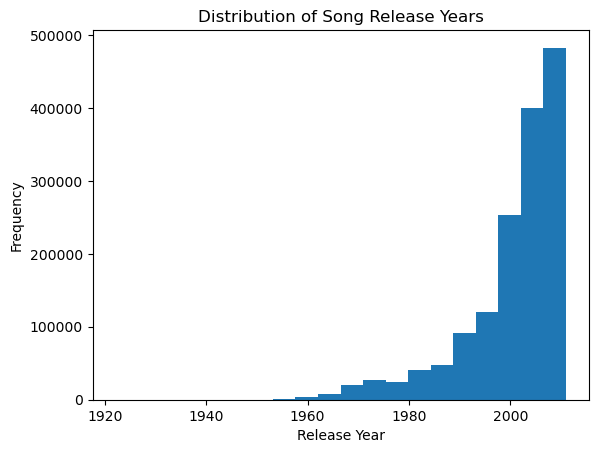

In [30]:
plt.hist(eda_data[eda_data['year']!=0]['year'], bins=20)
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.title('Distribution of Song Release Years')
plt.show()

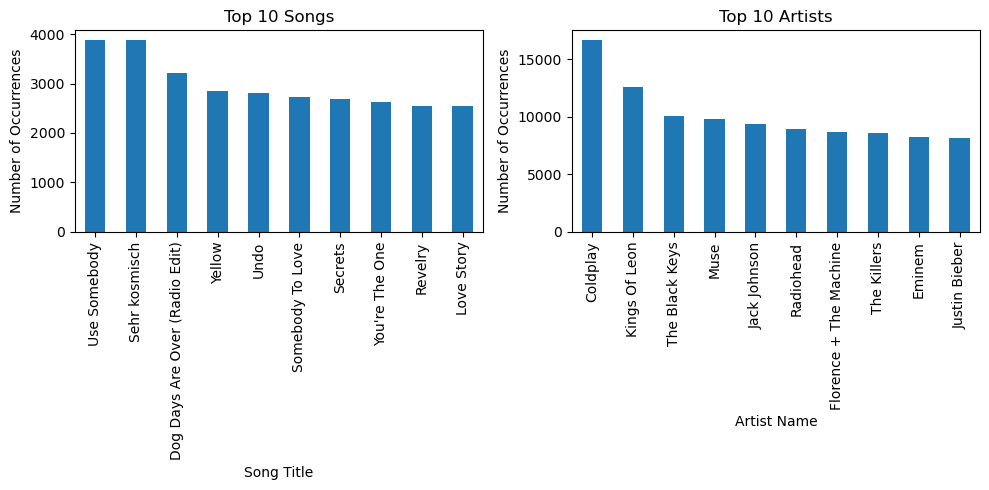

In [37]:
song_counts = eda_data['title'].value_counts()
artist_counts = eda_data['artist_name'].value_counts()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
song_counts[:10].plot(kind='bar')
plt.title('Top 10 Songs')
plt.xlabel('Song Title')
plt.ylabel('Number of Occurrences')
plt.subplot(1,2,2)
artist_counts[:10].plot(kind='bar')
plt.title('Top 10 Artists')
plt.xlabel('Artist Name')
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()

The average duration of songs is 248.57 seconds.


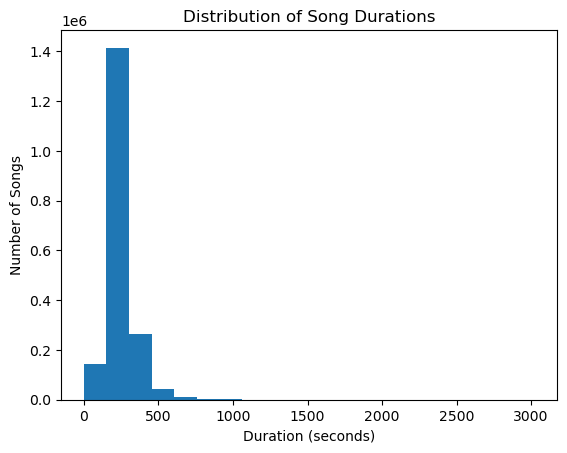

In [36]:
mean_duration = eda_data['duration'].mean()
print('The average duration of songs is {:.2f} seconds.'.format(mean_duration))

plt.hist(eda_data['duration'], bins=20)
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Songs')
plt.show()

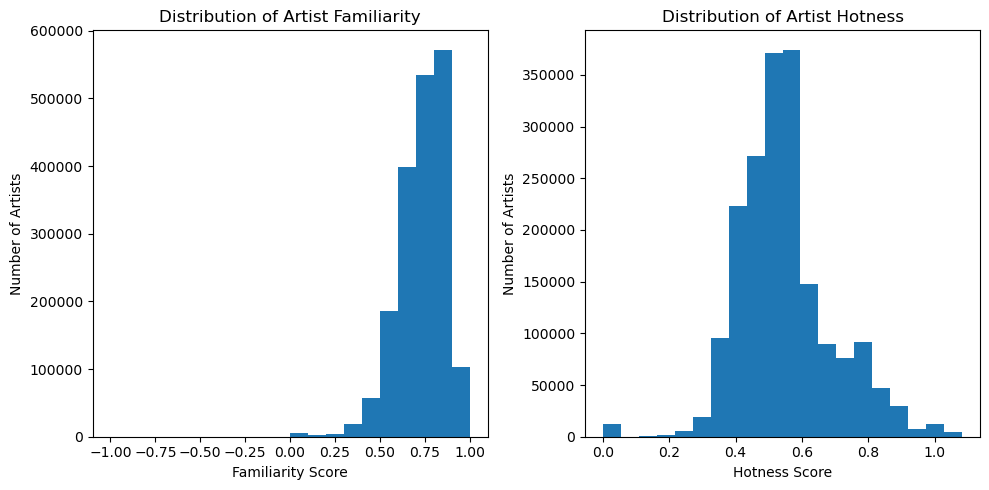

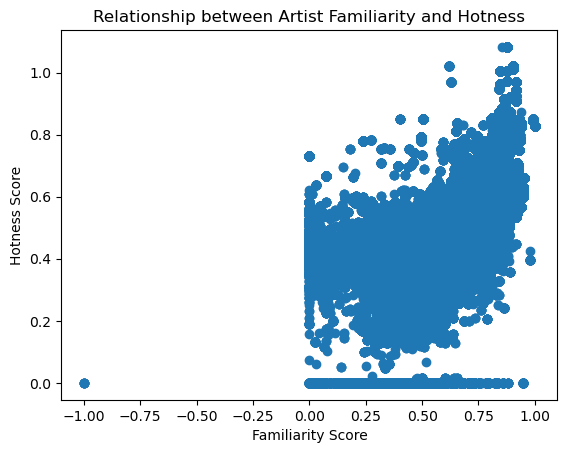

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(eda_data['artist_familiarity'], bins=20)
plt.title('Distribution of Artist Familiarity')
plt.xlabel('Familiarity Score')
plt.ylabel('Number of Artists')
plt.subplot(1,2,2)
plt.hist(eda_data['artist_hotttnesss'], bins=20)
plt.title('Distribution of Artist Hotness')
plt.xlabel('Hotness Score')
plt.ylabel('Number of Artists')
plt.tight_layout()
plt.show()

plt.scatter(eda_data['artist_familiarity'], eda_data['artist_hotttnesss'])
plt.title('Relationship between Artist Familiarity and Hotness')
plt.xlabel('Familiarity Score')
plt.ylabel('Hotness Score')
plt.show()

### TEXT PREPROCESSING

In [20]:
num_columns = ['song_id','duration', 'artist_familiarity', 'artist_hotttnesss', 'year']
text_columns = ['song_id','release','title', 'artist_name']
num_meta_df = metadata_df[num_columns].copy()
text_meta_df = metadata_df[text_columns].copy()

In [21]:
import re
# Preprocess song release,title, artist name
text_meta_df['release'] = text_meta_df['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['release'] = text_meta_df['release'].apply(lambda x: x.lower()) # Convert to lowercase
# text_meta_df['release'] = text_meta_df['release'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))])) # Remove stop words

text_meta_df['title'] = text_meta_df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['title'] = text_meta_df['title'].apply(lambda x: x.lower()) # Convert to lowercase
# text_meta_df['title'] = text_meta_df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))])) # Remove stop words

text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x))) # Remove punctuation
text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: x.lower()) # Convert to lowercase
# text_meta_df['artist_name'] = text_meta_df['artist_name'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))])) # Remove stop words


In [22]:
from gensim.models import Word2Vec

text_meta_df['text'] = text_meta_df[['release','title', 'artist_name']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in text_meta_df['text']]
emb_size = 500
# Train Word2Vec model
model_w2v = Word2Vec(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)


In [23]:
# Encode metadata using Word2Vec
meta_text_vec = []
for text in text_meta_df['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_w2v.wv:
            vec += model_w2v.wv[token]
    meta_text_vec.append(vec)
meta_text_vec = np.array(meta_text_vec)
meta_text_vec.shape

(189633, 500)

In [24]:
meta_embed = pd.concat([text_meta_df['song_id'],pd.DataFrame(meta_text_vec,columns = ['embed_{}'.format(i) for i in range(meta_text_vec.shape[1])])],axis = 1)
meta_embed.head()

,song_id,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,...,embed_490,embed_491,embed_492,embed_493,embed_494,embed_495,embed_496,embed_497,embed_498,embed_499
0,SOAKIMP12A8C130995,3.459586,2.818468,2.048239,1.157248,-1.559097,-3.432362,2.432063,5.023251,-1.434078,...,1.911688,-0.869168,0.623368,1.561162,-0.504498,0.366421,0.165279,-3.447769,-2.407705,-0.265385
1,SOAPDEY12A81C210A9,3.943554,7.783957,2.395405,3.924154,-1.090153,-7.000595,4.537427,5.420865,-0.517119,...,0.621522,-5.340216,-0.757952,1.576235,1.818998,2.487554,0.811014,-5.500037,-2.305865,-3.765372
2,SOBBMDR12A8C13253B,1.473728,-1.620696,1.683114,6.395366,-1.242066,-5.153045,-1.963623,1.113793,-0.018866,...,-1.491392,0.355332,3.433140,-1.642307,1.115882,-1.162770,0.595061,2.366619,-3.306341,-5.692612
3,SOBFNSP12AF72A0E22,6.430055,6.198054,4.159888,-0.885265,-3.974009,-5.090581,1.655470,8.636232,-2.050767,...,2.335559,0.685804,1.423723,2.986573,0.241086,0.720802,1.649229,-5.153775,-2.385250,-0.604622
4,SOBFOVM12A58A7D494,8.782164,9.753830,7.039066,10.312316,-3.538810,-14.875390,2.824638,12.084639,-2.713566,...,6.099036,-3.080500,0.869261,2.851289,-0.345833,-0.142963,0.256209,-6.392121,-3.706641,-2.785565


In [25]:
meta_data_df = pd.merge(taste_profile,meta_embed, on='song_id',how='left')

In [26]:
#Merging meta data into main dataframe
final_data_df = pd.merge(meta_data_df,num_meta_df,on='song_id',how="left")
final_data_df.head()

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_494,embed_495,embed_496,embed_497,embed_498,embed_499,duration,artist_familiarity,artist_hotttnesss,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,3.459586,2.818468,2.048239,1.157248,-1.559097,-3.432362,2.432063,...,-0.504498,0.366421,0.165279,-3.447769,-2.407705,-0.265385,112.63955,0.832012,0.677482,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,3.943554,7.783957,2.395405,3.924154,-1.090153,-7.000595,4.537427,...,1.818998,2.487554,0.811014,-5.500037,-2.305865,-3.765372,153.59955,0.580555,0.482492,1974
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1.473728,-1.620696,1.683114,6.395366,-1.242066,-5.153045,-1.963623,...,1.115882,-1.162770,0.595061,2.366619,-3.306341,-5.692612,358.24281,0.633119,0.417718,1976
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,6.430055,6.198054,4.159888,-0.885265,-3.974009,-5.090581,1.655470,...,0.241086,0.720802,1.649229,-5.153775,-2.385250,-0.604622,266.34404,0.675339,0.509058,2002
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,8.782164,9.753830,7.039066,10.312316,-3.538810,-14.875390,2.824638,...,-0.345833,-0.142963,0.256209,-6.392121,-3.706641,-2.785565,141.42649,0.650281,0.451749,0


#### TRAINING INPUT

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_data_df['play_count_norm'] = scaler.fit_transform(final_data_df['play_count'].values.reshape(-1, 1))
final_data_df.head()

,user_id,song_id,play_count,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_495,embed_496,embed_497,embed_498,embed_499,duration,artist_familiarity,artist_hotttnesss,year,play_count_norm
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,3.459586,2.818468,2.048239,1.157248,-1.559097,-3.432362,2.432063,...,0.366421,0.165279,-3.447769,-2.407705,-0.265385,112.63955,0.832012,0.677482,0,0.0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,3.943554,7.783957,2.395405,3.924154,-1.090153,-7.000595,4.537427,...,2.487554,0.811014,-5.500037,-2.305865,-3.765372,153.59955,0.580555,0.482492,1974,0.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,1.473728,-1.620696,1.683114,6.395366,-1.242066,-5.153045,-1.963623,...,-1.162770,0.595061,2.366619,-3.306341,-5.692612,358.24281,0.633119,0.417718,1976,0.2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,6.430055,6.198054,4.159888,-0.885265,-3.974009,-5.090581,1.655470,...,0.720802,1.649229,-5.153775,-2.385250,-0.604622,266.34404,0.675339,0.509058,2002,0.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,8.782164,9.753830,7.039066,10.312316,-3.538810,-14.875390,2.824638,...,-0.142963,0.256209,-6.392121,-3.706641,-2.785565,141.42649,0.650281,0.451749,0,0.0


In [28]:
# Generate random indices
num_samples = len(final_data_df)
indices = np.random.permutation(num_samples)

# Split indices into train and test
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use indices to index data
train_data = final_data_df.iloc[train_indices]
test_data = final_data_df.iloc[test_indices]

In [29]:
train_data.song_id= pd.Categorical(train_data.song_id) 
train_song_ids = train_data.song_id.cat.codes
train_data.user_id= pd.Categorical(train_data.user_id) 
train_user_ids = train_data.user_id.cat.codes
train_meta_array = train_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
train_output = train_data['play_count']


test_data.song_id= pd.Categorical(test_data.song_id) 
test_song_ids = test_data.song_id.cat.codes
test_data.user_id= pd.Categorical(test_data.user_id) 
test_user_ids = test_data.user_id.cat.codes
test_meta_array = test_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
test_output = test_data['play_count']


/tmp/ipykernel_152358/2909310003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.song_id= pd.Categorical(train_data.song_id)
/tmp/ipykernel_152358/2909310003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.user_id= pd.Categorical(train_data.user_id)
/tmp/ipykernel_152358/2909310003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

### 4 Training a Neural Network

#### 4.1 Input dimensions for neural network

In [30]:
#nunique() will return the total number of unique items

song_id = len(train_song_ids.unique()) 
user_id = len(train_user_ids.unique())
song_input_dim = 1#songs_input_data.shape[1]
user_input_dim = 1#user_input_data.shape[1]
meta_text_dim = train_meta_array.shape[1]

song_id,user_id,song_input_dim,user_input_dim,meta_text_dim

(173570, 41722, 1, 1, 504)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers


In [32]:
# Define input layer for interaction data
input_song = Input(shape=(song_input_dim,), name='song_input')
input_user = Input(shape=(user_input_dim,), name='user_input')

embedding_layer_songs = Embedding(song_id+1 ,10, embeddings_regularizer=regularizers.L2(0))(input_song)#Embedding layer
embedding_output_songs = Flatten()(embedding_layer_songs)#Embedding layer output

embedding_layer_users = Embedding(user_id+1 ,10, embeddings_regularizer=regularizers.L2(0))(input_user)#Embedding layer
embedding_output_users = Flatten()(embedding_layer_users)#Embedding layer output

# Define input layer for metadata
input_metadata = Input(shape=(meta_text_dim,), name='metadata_input')
# #AutoEncoder for meta data
x = Dense(128, activation='relu')(input_metadata)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
encoded = Dense(10, activation='relu', name='encoded_layer')(x)

# Define decoder layers for interaction data
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
metadata_embedding = Dense(meta_text_dim, name='decoded_layer')(x)

# x = tf.keras.layers.Multiply()([embedding_output_songs, embedding_output_users])
# Concatenate encoded interaction data and metadata
merged = tf.keras.layers.Concatenate()([embedding_output_songs, embedding_output_users, metadata_embedding])

# Define output layers for hybrid model
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, name='output_layer')(x) #,activation='sigmoid'

# Define full model
model1 = Model(inputs=[input_song, input_user, input_metadata], outputs=output)

# Compile model
model1.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])
model1.summary()

2023-04-27 20:58:47.456314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 metadata_input (InputLayer)    [(None, 504)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          64640       ['metadata_input[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dropout[0][0]']                
                                                                                              

In [33]:
#Training model

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

history = model1.fit(
  [train_song_ids, train_user_ids,train_meta_array], train_output, #
  batch_size=256, 
  epochs=20, 
  verbose=1,
  callbacks = [early_stopping],
  validation_split=0.2
)

2023-04-27 20:58:51.352181: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2560235328 exceeds 10% of free system memory.


Epoch 1/20
4961/4961 [==============================] - 68s 13ms/step - loss: 1.6931 - mae: 0.9254 - val_loss: 1.4348 - val_mae: 0.8742
Epoch 2/20
4961/4961 [==============================] - 63s 13ms/step - loss: 1.3782 - mae: 0.8386 - val_loss: 1.4309 - val_mae: 0.8718
Epoch 3/20
4961/4961 [==============================] - 63s 13ms/step - loss: 1.2924 - mae: 0.8053 - val_loss: 1.4494 - val_mae: 0.8800
Epoch 4/20
4961/4961 [==============================] - 60s 12ms/step - loss: 1.2158 - mae: 0.7714 - val_loss: 1.4835 - val_mae: 0.8719


In [35]:
from sklearn.metrics import mean_squared_error,r2_score
# Predict on test set
y_pred = model1.predict([test_song_ids,test_user_ids, test_meta_array])

# Evaluate model
score = model1.evaluate([test_song_ids,test_user_ids, test_meta_array], test_output, verbose=0)
rmse = np.sqrt(mean_squared_error(test_output, y_pred))
r2 = r2_score(test_output, y_pred)

print('Test RMSE:', rmse)
print('Test MSE:', score[0])
print('Test MAE:', score[1])


   27/12402 [..............................] - ETA: 23s  

2023-04-27 21:05:02.242537: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 800073792 exceeds 10% of free system memory.


12402/12402 [==============================] - 28s 2ms/step


2023-04-27 21:05:37.071951: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 800073792 exceeds 10% of free system memory.


Test RMSE: 1.4482647219587728
Test MSE: 2.0974745750427246
Test MAE: 1.0782930850982666


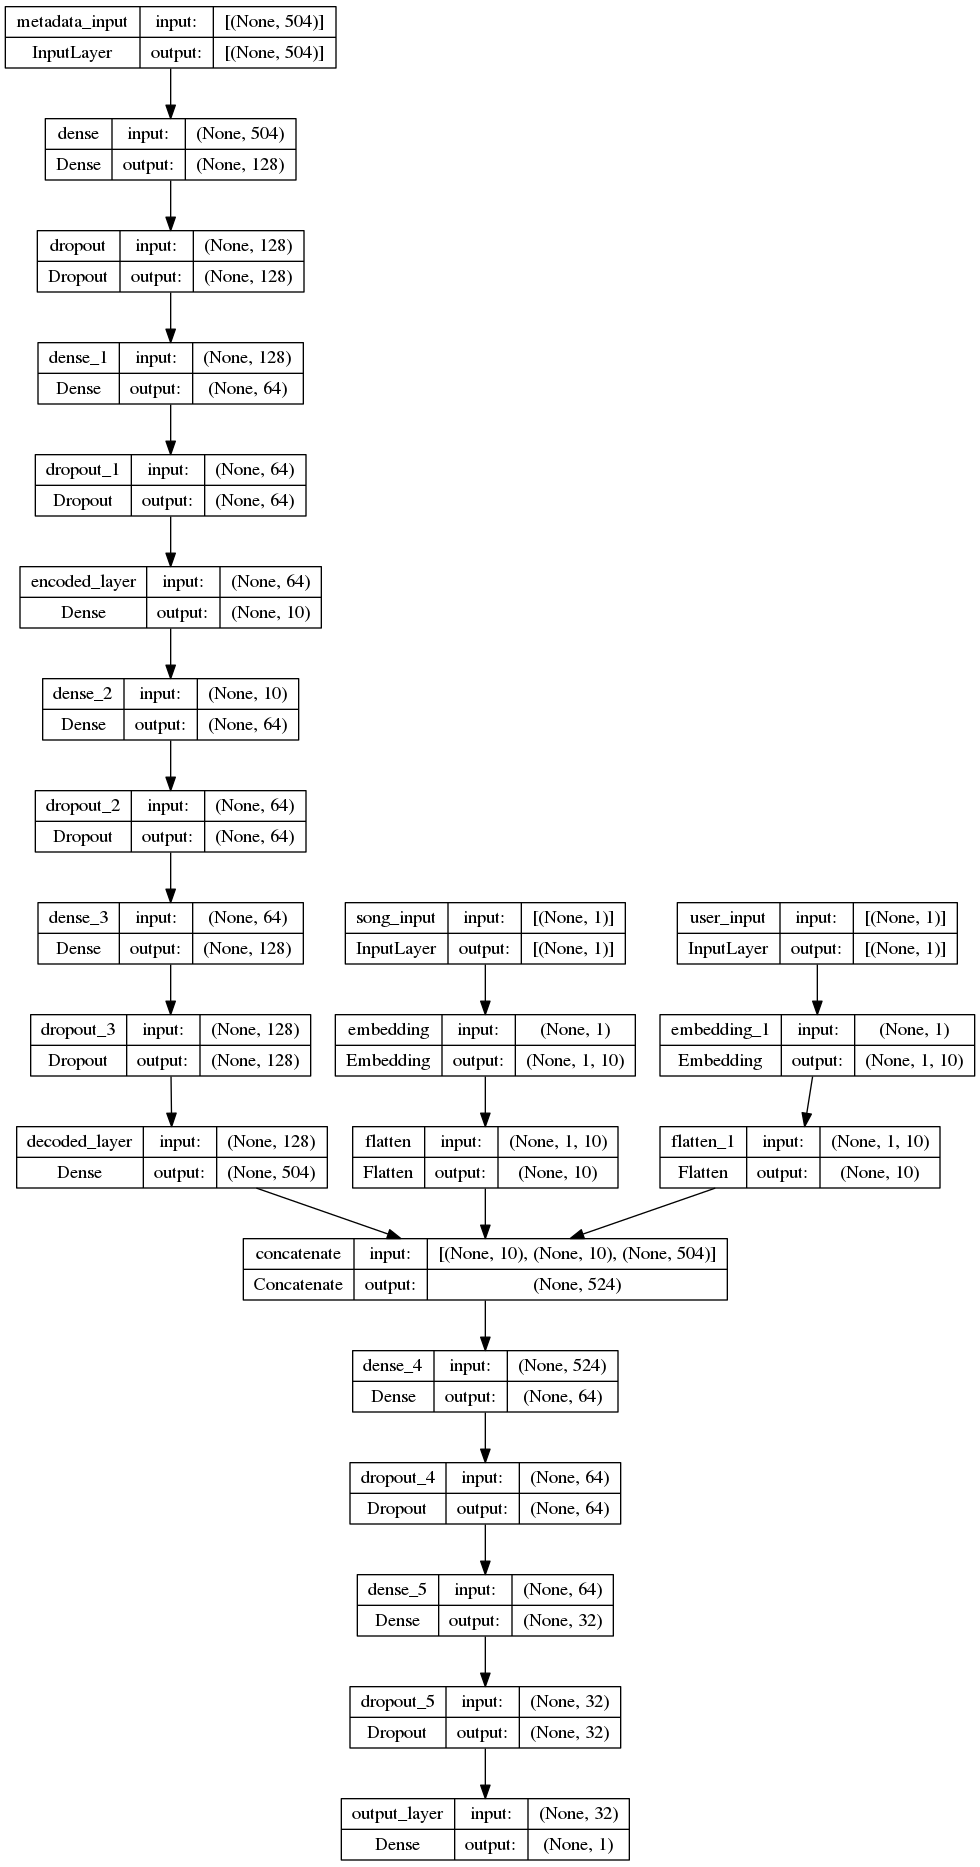

In [36]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model.png')

In [37]:
# Train model
# model.fit([np.vstack((train_song_ids,train_user_ids)).reshape(-1,2), train_meta_array],
#           train_output, epochs=10, batch_size=64, validation_split=0.2)

In [38]:
# # Predict on test set
# y_pred = model.predict([np.vstack((test_song_ids,test_user_ids)).reshape(-1,2), test_meta_array])

# # Evaluate model
# score = model.evaluate([np.vstack((test_song_ids,test_user_ids)).reshape(-1,2), test_meta_array], test_output, verbose=0)
# print('Test MSE:', score[0])
# print('Test MAE:', score[1])

### TRAINING A NEURAL NETWORK with normailized play count 

In [39]:
train_data.song_id= pd.Categorical(train_data.song_id) 
train_song_ids = train_data.song_id.cat.codes
train_data.user_id= pd.Categorical(train_data.user_id) 
train_user_ids = train_data.user_id.cat.codes
train_meta_array = train_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
train_output = train_data['play_count_norm']


test_data.song_id= pd.Categorical(test_data.song_id) 
test_song_ids = test_data.song_id.cat.codes
test_data.user_id= pd.Categorical(test_data.user_id) 
test_user_ids = test_data.user_id.cat.codes
test_meta_array = test_data.drop(columns=['song_id','user_id','play_count','play_count_norm']).values
test_output = test_data['play_count_norm']


/tmp/ipykernel_152358/3182804006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.song_id= pd.Categorical(train_data.song_id)
/tmp/ipykernel_152358/3182804006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.user_id= pd.Categorical(train_data.user_id)
/tmp/ipykernel_152358/3182804006.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

#### Input dimensions for neural network

In [40]:
#nunique() will return the total number of unique items

song_id = len(train_song_ids.unique()) 
user_id = len(train_user_ids.unique())
song_input_dim = 1
user_input_dim = 1
meta_text_dim = train_meta_array.shape[1]

song_id,user_id,song_input_dim,user_input_dim,meta_text_dim

(173570, 41722, 1, 1, 504)

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers


In [42]:
# Define input layer for interaction data
input_song = Input(shape=(song_input_dim,), name='song_input')
input_user = Input(shape=(user_input_dim,), name='user_input')

embedding_layer_songs = Embedding(song_id+1 ,10, embeddings_regularizer=regularizers.L2(0))(input_song)#Embedding layer
embedding_output_songs = Flatten()(embedding_layer_songs)#Embedding layer output

embedding_layer_users = Embedding(user_id+1 ,10, embeddings_regularizer=regularizers.L2(0))(input_user)#Embedding layer
embedding_output_users = Flatten()(embedding_layer_users)#Embedding layer output

# Define input layer for metadata
input_metadata = Input(shape=(meta_text_dim,), name='metadata_input')
# #AutoEncoder for meta data
x = Dense(128, activation='relu')(input_metadata)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
encoded = Dense(10, activation='relu', name='encoded_layer')(x)

# Define decoder layers for interaction data
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
metadata_embedding = Dense(meta_text_dim, name='decoded_layer')(x)

# x = tf.keras.layers.Multiply()([embedding_output_songs, embedding_output_users])
# Concatenate encoded interaction data and metadata
merged = tf.keras.layers.Concatenate()([embedding_output_songs, embedding_output_users, metadata_embedding])

# Define output layers for hybrid model
x = Dense(64, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, name='output_layer',activation='sigmoid')(x) #

# Define full model
model2 = Model(inputs=[input_song, input_user, input_metadata], outputs=output)

# Compile model
model2.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['mae'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 metadata_input (InputLayer)    [(None, 504)]        0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 128)          64640       ['metadata_input[0][0]']         
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_6[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 64)           8256        ['dropout_6[0][0]']              
                                                                                            

In [43]:
#Training model

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

history = model2.fit(
  [train_song_ids, train_user_ids,train_meta_array], train_output, #
  batch_size=256, 
  epochs=20, 
  verbose=1,
  callbacks = [early_stopping],
  validation_split=0.2
)

Epoch 1/20
4961/4961 [==============================] - 56s 11ms/step - loss: 0.4136 - mae: 0.1852 - val_loss: 0.3923 - val_mae: 0.1732
Epoch 2/20
4961/4961 [==============================] - 52s 10ms/step - loss: 0.3819 - mae: 0.1665 - val_loss: 0.3926 - val_mae: 0.1720
Epoch 3/20
4961/4961 [==============================] - 53s 11ms/step - loss: 0.3698 - mae: 0.1579 - val_loss: 0.3972 - val_mae: 0.1745


In [44]:
from sklearn.metrics import mean_squared_error,r2_score
# Predict on test set
y_pred = model2.predict([test_song_ids,test_user_ids, test_meta_array])

# Evaluate model
score = model2.evaluate([test_song_ids,test_user_ids, test_meta_array], test_output, verbose=0)
rmse = np.sqrt(mean_squared_error(test_output, y_pred))
r2 = r2_score(test_output, y_pred)

print('Test RMSE:', rmse)
print('Test MSE:', score[0])
print('Test MAE:', score[1])
print('Test R2:', r2)


12402/12402 [==============================] - 23s 2ms/step
Test RMSE: 0.2870037227414223
Test MSE: 0.48739001154899597
Test MAE: 0.21655012667179108
Test MAE: -0.25518796963453516
